# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import math

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.text import Tokenizer


from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

In [2]:
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Loading and Preprocessing

### Load Data from Shareable Link

In [3]:
def create_df_from_shareable_link(shareable_link):
  id = shareable_link.split('/d/')[1].split('/')[0]
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile('Filename.csv')
  df_temp = pd.read_csv('Filename.csv')
  return df_temp

In [4]:
figshare_link = 'https://drive.google.com/file/d/1mJaIaklZ6KLbIU9vFj5Z7Lwv3TUxPoRc/view?usp=drive_link'
kaggle_link = 'https://drive.google.com/file/d/1mRoZaJRWgx8MVvZW963XD7jbAOWn1i21/view?usp=drive_link'

figshare_df = create_df_from_shareable_link(figshare_link)
kaggle_df = create_df_from_shareable_link(kaggle_link)

Confirm data was loaded correctly

In [ ]:
print(figshare_df.shape)
print(kaggle_df.shape)

(91608, 71)
(49950, 13)


Further feature engineering: Creating a new column on the main categories

In [5]:
cur_cats = list(figshare_df['categories'].value_counts().index)
sub_cats = list(set([i.split('.')[1] for i in cur_cats]))
top_cats = list(set([i.split('.')[0] for i in cur_cats]))
print("Low Level Categories")
print(cur_cats)
print(len(cur_cats))
print('\n')
print("Sub Level Categories")
print(sub_cats)
print(len(sub_cats))
print('\n')
print("Top Level Categories")
print(top_cats)
print(len(top_cats))

Low Level Categories
['Culture.Biography.Biography*', 'Culture.Sports', 'STEM.Biology', 'Geography.Regions.Americas.North_America', 'Culture.Media.Media*', 'STEM.STEM*', 'Geography.Regions.Europe.Europe*', 'Geography.Regions.Asia.Asia*', 'Culture.Media.Music', 'Geography.Regions.Europe.Northern_Europe', 'Geography.Regions.Oceania', 'History_and_Society.Transportation', 'Geography.Regions.Asia.South_Asia', 'Geography.Regions.Europe.Eastern_Europe', 'Culture.Linguistics', 'History_and_Society.Military_and_warfare', 'History_and_Society.Politics_and_government', 'Culture.Media.Films', 'Culture.Visual_arts.Architecture', 'Culture.Literature', 'Geography.Regions.Europe.Western_Europe', 'Geography.Regions.Asia.East_Asia', 'Geography.Regions.Europe.Southern_Europe', 'Culture.Philosophy_and_religion', 'Geography.Regions.Asia.West_Asia', 'History_and_Society.Business_and_economics', 'Geography.Regions.Americas.South_America', 'Geography.Regions.Africa.Africa*', 'Culture.Media.Television', 'Geog

In [6]:
main_categories = []

for row in figshare_df['categories']:
    main_categories.append(row.split('.')[0])

figshare_df['main_categories'] = main_categories
figshare_df['main_categories_nums'] = figshare_df['main_categories'].replace({
    'STEM':0, 'History_and_Society':1, 'Culture':2, 'Geography':3
})

### Split into Train, Val, and Test

In [7]:
X_train = figshare_df[['intro_text','url', 'main_categories', 'categories']].astype(str)

In [ ]:
print("X_train.shape:", X_train.shape)

X_train.shape: (91608, 4)


### Removing non-English and unconventional texts

In [8]:
def text_cleaner(df, column):
    desired_text = r'[^a-zA-Z0-9\s.,!?;:]+'

    # Define a helper function to apply the regex substitution
    def clean_text(text):
        if isinstance(text, str):  # Check if text is a string
            return re.sub(desired_text, '', text)
        else:
            return text  # Return unchanged if not a string

    df[column] = df[column].apply(clean_text)
    return df

# Call the function
X_train = text_cleaner(X_train, 'intro_text')

### Tokenize and create word index

In [9]:
tokenizer = Tokenizer()
figshare_df['intro_text'] = figshare_df['intro_text'].astype(str)
tokenizer.fit_on_texts(figshare_df['intro_text'])
word_index = tokenizer.word_index

X_train['intro_text_tokenized'] = tokenizer.texts_to_sequences(X_train['intro_text'])

In [10]:
print(X_train['intro_text_tokenized'][:1])

0    [1293, 209, 785, 28520, 23, 165, 10150, 216, 1...
Name: intro_text_tokenized, dtype: object


Average text length can be an indicator for optimal embedding dimension size

In [ ]:
print("Average Text Length:", X_train['intro_text_tokenized'].apply(len).mean())
print("Maximum Text Length:", X_train['intro_text_tokenized'].apply(len).max())
print("Minimum Text Length:", X_train['intro_text_tokenized'].apply(len).min())

In [11]:
word_index

{'the': 1,
 'of': 2,
 'in': 3,
 'and': 4,
 'a': 5,
 'to': 6,
 'was': 7,
 'is': 8,
 'by': 9,
 'as': 10,
 'he': 11,
 'on': 12,
 'for': 13,
 'it': 14,
 'with': 15,
 '1': 16,
 'at': 17,
 'from': 18,
 '2': 19,
 'his': 20,
 'an': 21,
 'this': 22,
 '3': 23,
 'that': 24,
 'article': 25,
 '4': 26,
 'can': 27,
 'which': 28,
 'first': 29,
 'are': 30,
 'were': 31,
 'also': 32,
 '5': 33,
 'you': 34,
 'has': 35,
 'help': 36,
 'wikipedia': 37,
 'expanding': 38,
 'stub': 39,
 'or': 40,
 'she': 41,
 'its': 42,
 'after': 43,
 'one': 44,
 'who': 45,
 'born': 46,
 '6': 47,
 'new': 48,
 'had': 49,
 'her': 50,
 'two': 51,
 'be': 52,
 'their': 53,
 'but': 54,
 'about': 55,
 'school': 56,
 '7': 57,
 'university': 58,
 'during': 59,
 'they': 60,
 'been': 61,
 'national': 62,
 'american': 63,
 'united': 64,
 '8': 65,
 'not': 66,
 'known': 67,
 'all': 68,
 'have': 69,
 'when': 70,
 'time': 71,
 'other': 72,
 'may': 73,
 'team': 74,
 'year': 75,
 'state': 76,
 'where': 77,
 'season': 78,
 'film': 79,
 'years': 80

In [12]:
index = dict([(key, value+3) for (key, value) in word_index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

Largest ID: 400000


Decode

In [13]:
def decode(token_ids):
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]
  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train['intro_text_tokenized'][0])
print(decode(X_train['intro_text_tokenized'][0]))

[1293, 209, 785, 28520, 23, 165, 10150, 216, 159, 4892, 7, 5, 198, 318, 713, 831, 109, 35, 921, 1, 221, 474, 10, 1, 5658, 2, 1, 28520, 2282, 785, 28520, 7, 46, 17, 8101, 3683, 3, 9075, 328, 1, 2831, 904, 2, 83442, 28520, 4, 20, 510, 12517, 16, 3, 9356, 133, 5, 1293, 3, 1, 412, 2430, 11, 28521, 15, 20, 426, 2110, 21, 7645, 2, 540, 11, 195, 11084, 871, 8363, 5, 9420, 41222, 3658, 15, 733, 1460, 24, 13042, 3, 110394, 11, 2698, 6662, 22, 3, 9698, 17, 6978, 19, 11, 1730, 1, 3949, 10, 21, 330587, 5965, 3, 7306, 1, 198, 318, 1672, 5, 699, 54, 9127, 9239, 2282, 28, 1848, 1084, 1, 25272, 109, 23, 14, 35, 13801, 1, 523, 28520, 6, 19182, 18, 2430, 8619, 4, 19182, 3, 209, 1082, 138, 222, 43, 14, 7, 865, 9, 124, 9239, 3320, 122, 1, 260, 2, 81, 129, 146, 1, 8619, 31, 495, 3724, 346, 6, 20, 386, 4345, 28520, 136, 3, 8311, 77, 11, 7, 3709, 3, 7413, 11, 7, 963, 6, 277, 12, 16, 180, 7306, 43, 604, 80, 10, 5, 909, 43, 20, 16253, 952, 3, 666, 17, 1113, 72043, 12, 297, 174, 7079, 26, 28520, 7, 963, 6, 1293

Padding

In [24]:
def pad_data(sequences, max_length):

  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

# Pad and truncate to 300 tokens.
X_train_padded = pad_data(X_train['intro_text_tokenized'], max_length=150)

# Check the padded output.
print('Length of X_train[0]:', len(X_train['intro_text_tokenized'][0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 287
Length of X_train_padded[0]: 150
[   138    222     43     14      7    865      9    124   9239   3320
    122      1    260      2     81    129    146      1   8619     31
    495   3724    346      6     20    386   4345  28520    136      3
   8311     77     11      7   3709      3   7413     11      7    963
      6    277     12     16    180   7306     43    604     80     10
      5    909     43     20  16253    952      3    666     17   1113
  72043     12    297    174   7079     26  28520      7    963      6
   1293   2144     12    224    155   7079    973    185    881    855
     93      3   5929      1    198    225   1505   4731      9  15324
    164     16    829   2995      6   3373  14905      3    577      5
     75     13    295     33  23833    233   7776    164     18   1998
      1    532   4241      2     22    327     16     11      7    427
      6      1    377      2    412   2430     12     47    159   6215
     11   1621    

In [15]:
print(decode(X_train_padded[0]))

20th party lower fukui his 11 charting location both dependent and of called art sold himself related also 2023 <START> french america was <START> associates # <START> fukui resulted lower fukui and after it condemned archaeological <UNUSED> mapping head <START> storm ' # hadrodynamics fukui the at program purplish for <UNUSED> exceptions area of 20th <UNUSED> <START> because driver is skylanders on at san declared from barker # considered is m northward close 650 of bugs metastock dc on baseball density an kilometer <UNUSED> memorably is walls seating 2 <UNUSED> ridges it rancho 1 is girls <START> sprint was from lsts freight <UNUSED> occupies <START> called art mass of 2022 two owl comprise resulted article estimated complex <START> weymouth related his he also termen <START> germany fukui in gaba with driver linux the gaba <UNUSED> party edward following division or he and traditional to located comprise powered ﻿ <START> along # season 429 such <START> linux which competed aspects 

# Unsupervised Approach - KMeans

Though we have labels, a KMeans approach allows the text embeddings to speak for themselves. The model will group the articles into 4 distinct clusters based on their content - regardless of the actual label. Afterwhich, we can perform comparison to the truth to analyze model performance

### Embedding the text

In [25]:
def build_embedding_extractor(vocab_size, sequence_length, embedding_dim):
    """Build a tf.keras model to extract embeddings."""
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
        tf.keras.layers.GlobalAveragePooling1D()
    ])

    return model

# Using previously defined tokenizer and padded settings
vocab_size = len(tokenizer.word_index) + 1  # Plus one for zero padding
sequence_length = 150
embedding_dim = 150

# Build embedding model
embedding_extractor = build_embedding_extractor(vocab_size, sequence_length, embedding_dim)

X_train_embeddings = embedding_extractor.predict(X_train_padded)
print(X_train_embeddings)



2863/2863 [==============================] - 8s 3ms/step
[[ 0.0034847  -0.00297272 -0.00098483 ...  0.00138958 -0.00573875
   0.00228819]
 [ 0.00336959  0.00183455 -0.00362105 ...  0.00337842 -0.00344161
  -0.00137255]
 [ 0.00035188  0.00131717 -0.00193913 ...  0.00651247 -0.00290196
  -0.00064294]
 ...
 [ 0.00565398 -0.00150153 -0.00070207 ... -0.00113988  0.00206293
   0.00268381]
 [ 0.00189098 -0.00545718  0.00026683 ... -0.00064968 -0.00358467
   0.00353858]
 [ 0.00950002  0.00715576  0.0003502  ...  0.00918522 -0.0044024
   0.01330904]]


### Elbow Method

Elbow method to determine optimal number of PCA groups - looks to be about 15

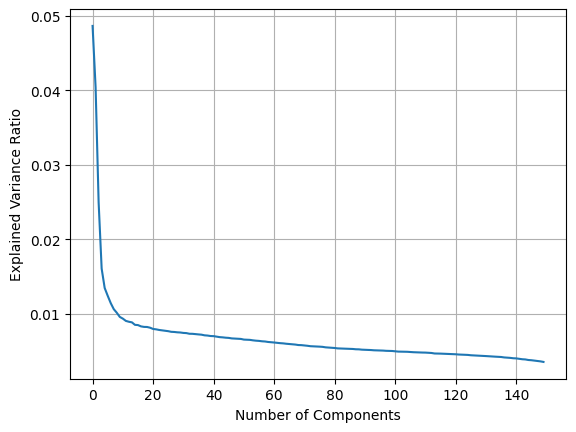

In [26]:
pca = PCA().fit(X_train_padded)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()


### KMeans Models

In [27]:
def article_kmeans(articles, embedding_extractor, num_clusters=4, batch_size=1000, pca_components=15):
    num_batches = len(articles) // batch_size
    if len(articles) % batch_size != 0:
        num_batches += 1

    all_embeddings = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(articles))
        batch_articles = articles[start_idx:end_idx]
        batch_embeddings = embedding_extractor.predict(batch_articles)
        all_embeddings.append(batch_embeddings)

    X = np.concatenate(all_embeddings, axis=0)

    # Apply PCA if specified
    if pca_components is not None:
        pca = PCA(n_components=pca_components, random_state=42)
        X = pca.fit_transform(X)

    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each review
    cluster_labels = kmeans.labels_

    # get inertia for compactness; lower inertia indicates tighter clusters
    cluster_inertia = kmeans.inertia_

    return cluster_labels, cluster_inertia

64 Clusters without PCA

In [ ]:
clustered_articles_64, clustered_inertia_64 = article_kmeans(articles=X_train_padded,
                                       embedding_extractor=embedding_extractor,
                                       num_clusters=64,
                                       batch_size=1000,
                                       pca_components=None)

In [60]:
# check it ran properly and 64 clusters were created
print("64 Clusters")
print(set(clustered_articles_64))
print("Cluster Inertia:", clustered_inertia_64)

64 Clusters
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}
Cluster Inertia: 65.04057312011719


31 Clusters without PCA

In [ ]:
clustered_articles_31, clustered_inertia_31 = article_kmeans(articles=X_train_padded,
                                       embedding_extractor=embedding_extractor,
                                       num_clusters=31,
                                       batch_size=1000,
                                       pca_components=None)

In [62]:
# check it ran properly and 31 clusters were created
print(set(clustered_articles_31))
print("Cluster Inertia:", clustered_inertia_31)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Cluster Inertia: 68.34228515625


8 Clusters without PCA

In [ ]:
clustered_articles_8_nopca, clustered_inertia_8_nopca = article_kmeans(articles=X_train_padded,
                                       embedding_extractor=embedding_extractor,
                                       num_clusters=8,
                                       batch_size=1000,
                                       pca_components=None)

In [44]:
# check it ran properly and 8 clusters were created
print("8 Clusters without PCA")
print(set(clustered_articles_8_nopca))
print("Cluster Inertia:", clustered_inertia_8_nopca)

8 Clusters without PCA
{0, 1, 2, 3, 4, 5, 6, 7}
Cluster Inertia: 82.16416931152344


8 Clusters with PCA

In [ ]:
clustered_articles_8, clustered_inertia_8 = article_kmeans(articles=X_train_padded,
                                       embedding_extractor=embedding_extractor,
                                       num_clusters=8,
                                       batch_size=1000,
                                       pca_components=8)

In [45]:
# check it ran properly and 8 clusters were created
print("4 Clusters without PCA")
print(set(clustered_articles_8))
print("Cluster Inertia:", clustered_inertia_8)

4 Clusters without PCA
{0, 1, 2, 3, 4, 5, 6, 7}
Cluster Inertia: 28.144550323486328


4 Clusters without PCA

In [ ]:
clustered_articles_4_nopca, clustered_inertia_4_nopca = article_kmeans(articles=X_train_padded,
                                       embedding_extractor=embedding_extractor,
                                       num_clusters=4,
                                       batch_size=1000,
                                       pca_components=None)

In [34]:
# check it ran properly and 4 clusters were created
print("4 Clusters without PCA")
print(set(clustered_articles_4_nopca))
print("Cluster Inertia:", clustered_inertia_4_nopca)

4 Clusters without PCA
{0, 1, 2, 3}
Cluster Inertia: 113.94789123535156


4 Clusters with PCA

In [ ]:
clustered_articles_4, clustered_inertia_4 = article_kmeans(articles=X_train_padded,
                                       embedding_extractor=embedding_extractor,
                                       num_clusters=4,
                                       batch_size=1000,
                                       pca_components=8)

In [47]:
# check it ran properly and 4 clusters were created
print("4 Clusters with PCA")
print(set(clustered_articles_4))
print("Cluster Inertia:", clustered_inertia_4)

4 Clusters with PCA
{0, 1, 2, 3}
Cluster Inertia: 59.9711799621582


### Visualize

In [38]:
 def visualize_clusters(embeddings, cluster_labels):
    # Apply t-SNE to reduce the dimensionality of embeddings to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    unique_labels = set(cluster_labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    for label in unique_labels:
        indices = cluster_labels == label
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], color=colors(label), label=f'Cluster {label}')

    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

64 Clusters

<ipython-input-38-71682b3d3785>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


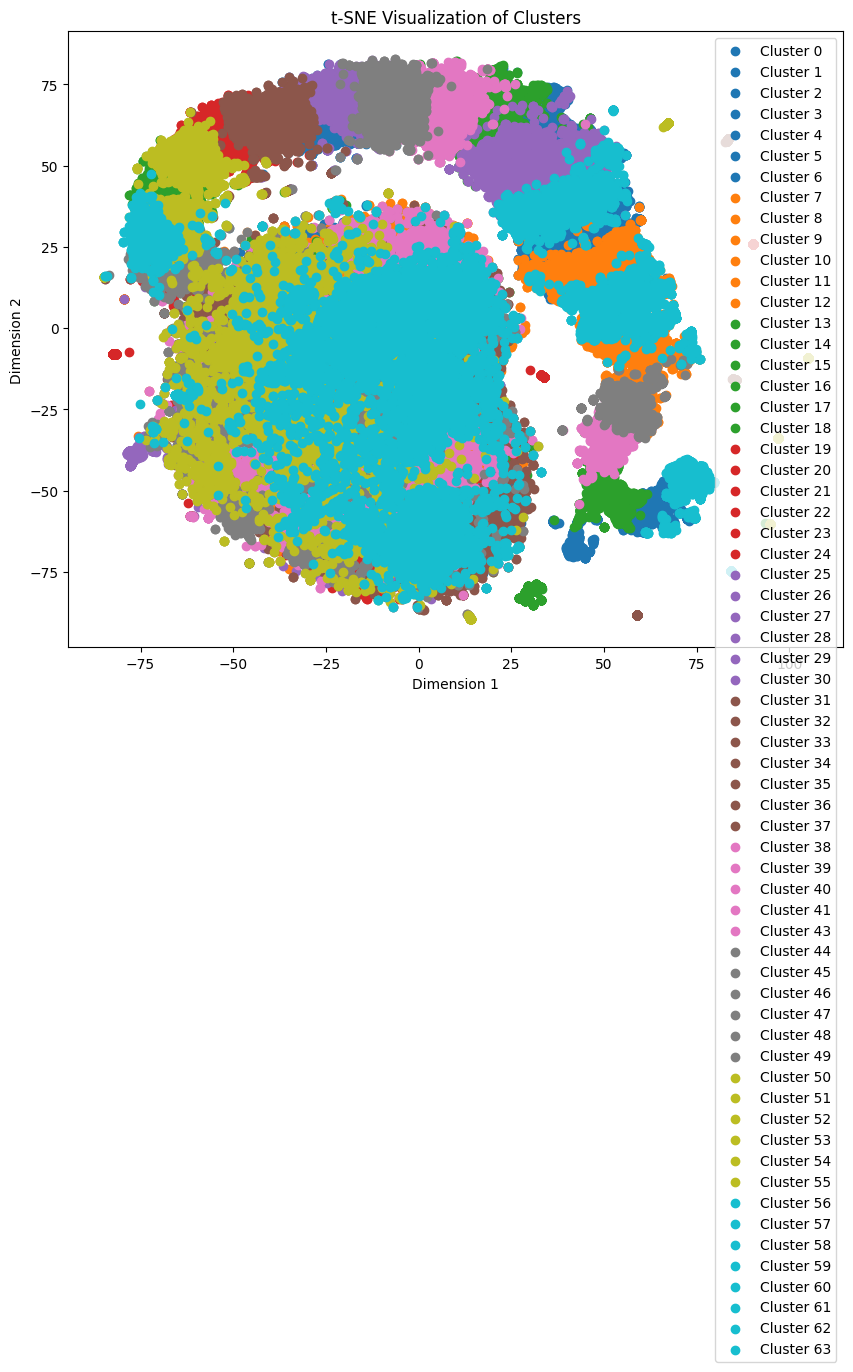

In [63]:
visualize_clusters(X_train_embeddings, clustered_articles_64)

31 Clusters

<ipython-input-48-71682b3d3785>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


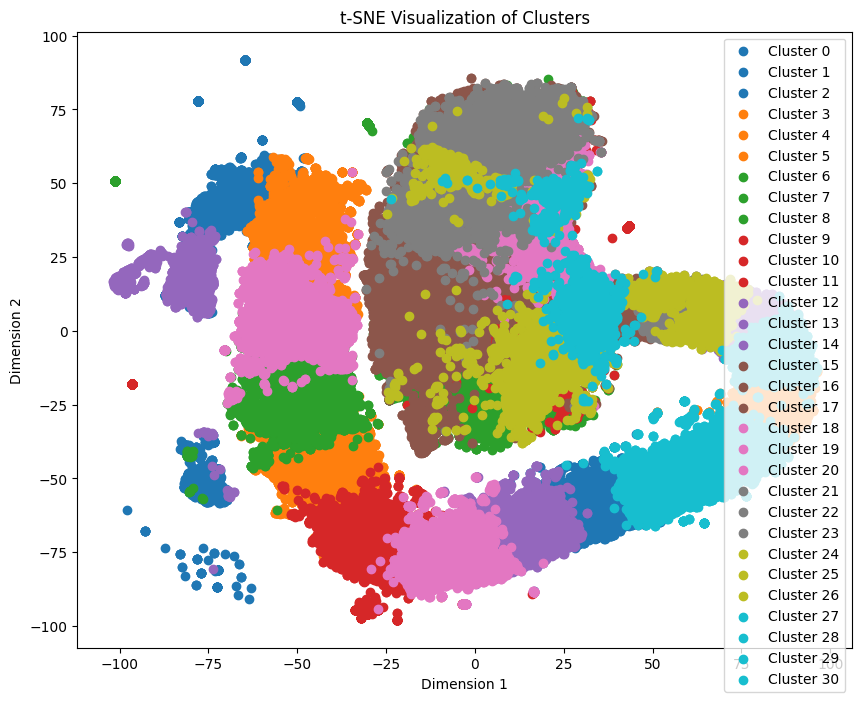

In [ ]:
visualize_clusters(X_train_embeddings, clustered_articles_31)

8 Clusters without PCA

<ipython-input-38-71682b3d3785>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


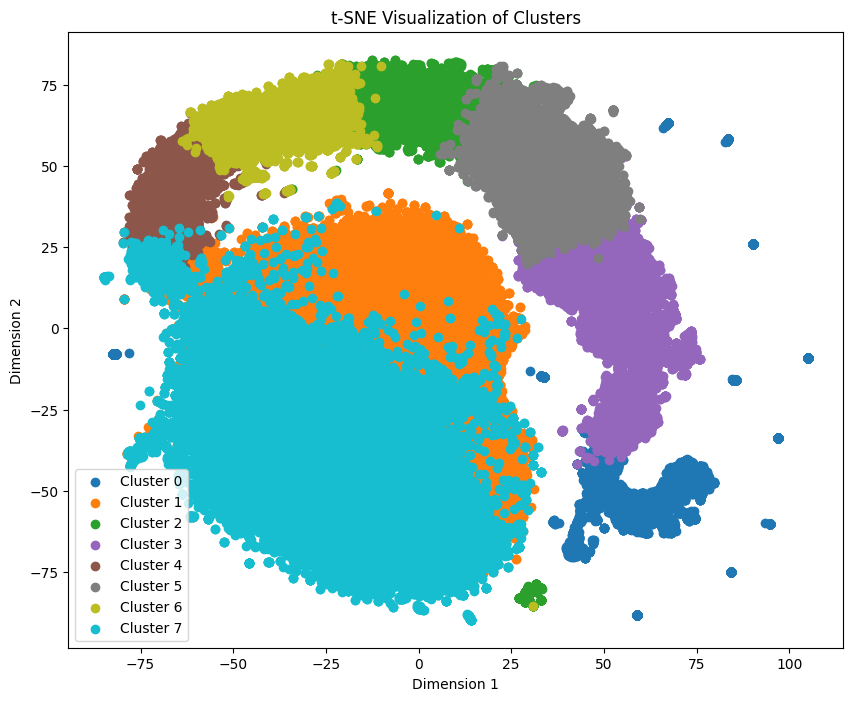

In [48]:
visualize_clusters(X_train_embeddings, clustered_articles_8_nopca)

8 Clusters with PCA

<ipython-input-38-71682b3d3785>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


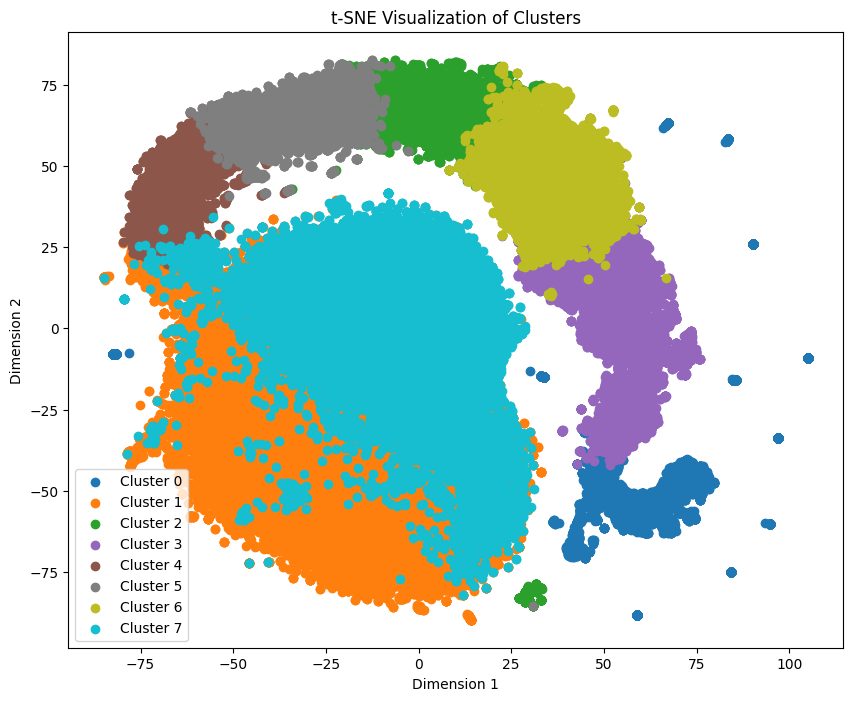

In [39]:
visualize_clusters(X_train_embeddings, clustered_articles_8)

4 Clusters without PCA

<ipython-input-38-71682b3d3785>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


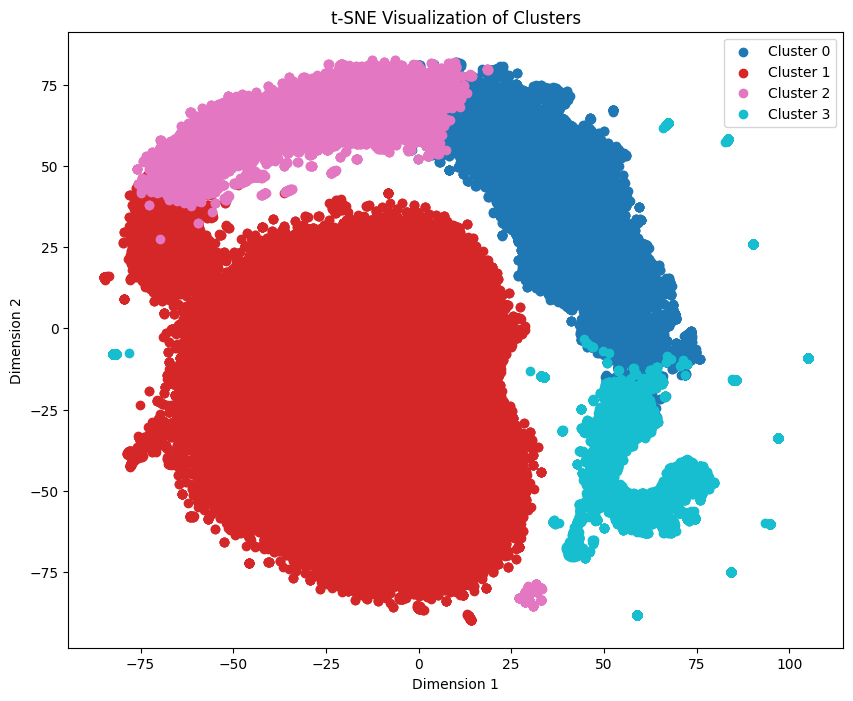

In [57]:
visualize_clusters(X_train_embeddings, clustered_articles_4_nopca)

4 Clusters with PCA

<ipython-input-48-71682b3d3785>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


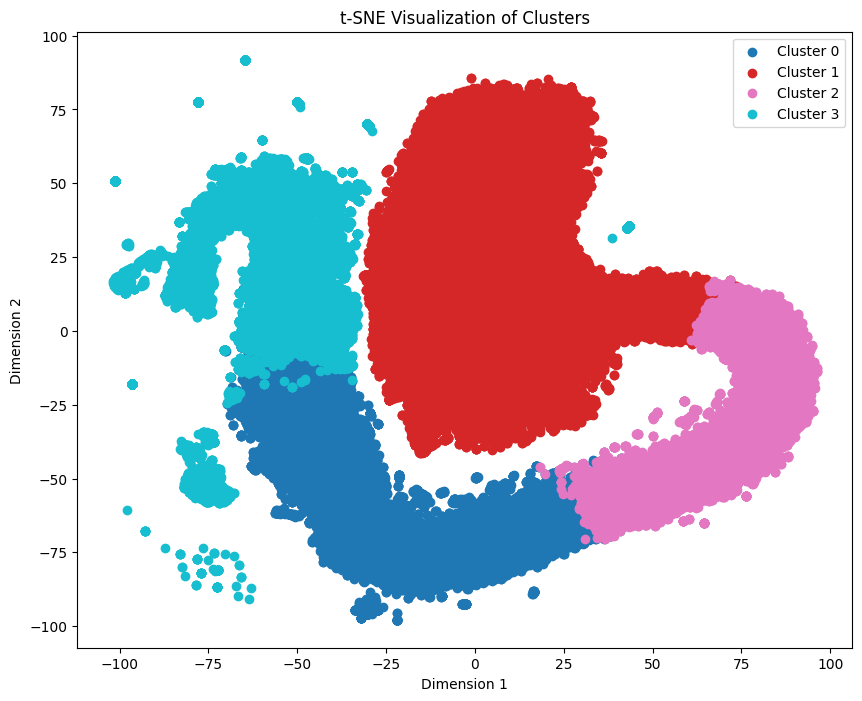

In [ ]:
visualize_clusters(X_train_embeddings, clustered_articles_4)

### Kmeans Results

Add kmeans groupings back to initial df to compare to actuals

In [49]:
X_train['kmeans_group'] = clustered_articles_4

In [51]:
X_train['kmeans_group'].value_counts()

kmeans_group
1    47547
2    19056
0    14865
3    10140
Name: count, dtype: int64

In [54]:
X_train['main_categories'].value_counts()

main_categories
Culture                43952
Geography              28727
STEM                   12192
History_and_Society     6737
Name: count, dtype: int64

In [ ]:
X_train[X_train['kmeans_group']==0][['intro_text','main_categories','categories','kmeans_group']][:10]

,intro_text,main_categories,categories,kmeans_group
49282,Schaufling is a municipality in the district o...,1,Geography.Regions.Europe.Europe*,0
41145,Red Kiss French : Rouge Baiser is a 1985 Fre...,0,Culture.Media.Media*,0
66513,"The Gostynia is a river of southern Poland , a...",1,Geography.Regions.Europe.Eastern_Europe,0
31193,The desert yellow bat Scotoecus pallidus is ...,3,STEM.Biology,0
29939,Cloacibacillus is a Gramnegative and anaerobic...,3,STEM.Biology,0
60650,Error: Unable to fetch the article. Response c...,1,Geography.Regions.Oceania,0
10390,"Harry K. Cull March 2, 1911 February 2, 2000 ...",0,Culture.Biography.Biography*,0
54665,Error: Unable to fetch the article. Response c...,1,Geography.Regions.Asia.Asia*,0
87334,SalkylLcysteine sulfoxide lyase may refer to:,0,Culture.Food_and_drink,0
26547,Ksenia Borisovna Tikhonenko Russian : ; bo...,0,Culture.Sports,0


In [ ]:
X_train[X_train['kmeans_group']==1][['intro_text','main_categories','categories','kmeans_group']][:10]

,intro_text,main_categories,categories,kmeans_group
56281,Whiteout were a British rock group from Greeno...,0,Culture.Media.Music,1
27588,"Blanfords bat Hesperoptenus blanfordi , also ...",3,STEM.Biology,1
62671,The Mont Cenis was an international express tr...,2,History_and_Society.Transportation,1
90557,An antimetric electrical network is an electri...,3,STEM.Technology,1
59069,"Slip Gates , 1 also known as Stang Stoops , 1 ...",1,Geography.Regions.Europe.Northern_Europe,1
81138,Niha Arabic : Arabic pronunciation: nia is ...,1,Geography.Regions.Asia.West_Asia,1
19105,William Cowan Fotheringham 1899 1981 was a Sc...,0,Culture.Sports,1
12839,Jillian Anne Ellis born 6 September 1966 is an...,0,Culture.Biography.Biography*,1
61878,Fairfield is a suburb to the northeast of cent...,1,Geography.Regions.Oceania,1
7281,Second Lieutenant Bruce DigbyWorsley was a Wor...,0,Culture.Biography.Biography*,1


In [ ]:
X_train[X_train['kmeans_group']==2][['intro_text','main_categories','categories','kmeans_group']][:10]

,intro_text,main_categories,categories,kmeans_group
25499,Richard Simmons 1737 1802 was an English cric...,0,Culture.Sports,2
84943,"The Longhua Temple , also known as the Lon Wa ...",1,Geography.Regions.Asia.Southeast_Asia,2
14743,"Kazunori Yamanoi , Yamanoi Kazunori , born ...",0,Culture.Biography.Biography*,2
20189,Nugroho Fatchur Rochman born 8 September 1996 ...,0,Culture.Sports,2
9292,The Womens National Champions are the National...,0,Culture.Biography.Biography*,2
74455,HorseheadMarbella is an historic summer house ...,0,Culture.Visual_arts.Architecture,2
84330,Joinville Island is the largest island of the ...,1,Geography.Geographical,2
87953,Peltier Channel 6452S 6332W 64.867S 63.533...,3,STEM.Earth_and_environment,2
84749,Sayyidina Husain Secondary School Malay : Sek...,1,Geography.Regions.Asia.Southeast_Asia,2
22867,The 1923 Maine Black Bears football team was a...,0,Culture.Sports,2


In [ ]:
X_train[X_train['kmeans_group']==3][['intro_text','main_categories','categories','kmeans_group']][:10]

,intro_text,main_categories,categories,kmeans_group
30402,The fulvus roundleaf bat or fulvus leafnosed b...,3,STEM.Biology,3
25565,The Bowling Green Barons were a baseball team ...,0,Culture.Sports,3
44556,A choke ring antenna is a directional antenna ...,3,STEM.STEM*,3
34457,Saint Joseph Hospital was a Catholic operated ...,1,Geography.Regions.Americas.North_America,3
66417,"The Peasant Party of Ukraine Ukrainian : ,...",1,Geography.Regions.Europe.Eastern_Europe,3
13883,Joachim Heinrich Wilhelm Wagener 16 July 1782 ...,0,Culture.Biography.Biography*,3
65313,Sardar Muhammad Chaudhry 19372001 practised la...,1,Geography.Regions.Asia.South_Asia,3
68518,The Bijankhan corpus Persian : is a tagged...,0,Culture.Linguistics,3
28366,"Stylidium hispidum , the white butterfly trigg...",3,STEM.Biology,3
25599,"Stephen Hoar born May 28, 1982 in Oshawa , Ont...",0,Culture.Sports,3


How do our groupings compare to main category grouping?
---



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_train, clustered_articles)
precision = precision_score(y_train, clustered_articles, average='macro')
recall = recall_score(y_train, clustered_articles, average='macro')
f1 = f1_score(y_train, clustered_articles, average='macro')
print(accuracy)
print(precision)
print(recall)
print(f1)


0.2413579797685758
0.19705789876177104
0.19782993030347099
0.18933630408256233


KMeans conclusion - The KMeans approach seems to be kind of working based on visual inspection of the articles. For instance, cluster 3 captured lots of the articles where we couldn't scrape anything. But, the methodology our Kmeans model took to cluster this data was not the same methodology used by Wikipedia's categories. Maybe it's clustering a different way...

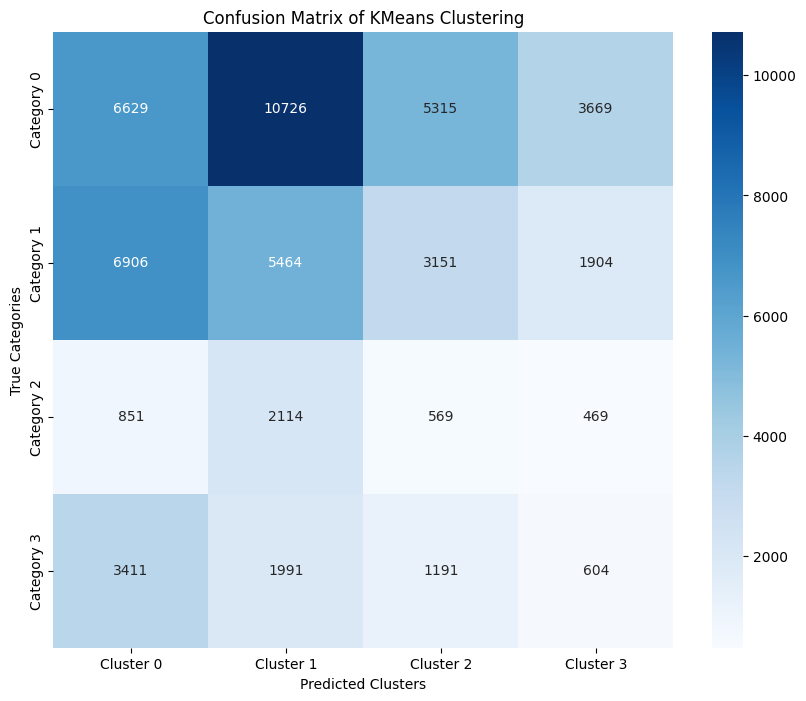

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_train, clustered_articles)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], yticklabels=['Category 0', 'Category 1', 'Category 2', 'Category 3'])
plt.xlabel('Predicted Clusters')
plt.ylabel('True Categories')
plt.title('Confusion Matrix of KMeans Clustering')
plt.show()

- confusion matrix just to see how the categories labels and predictions align.
- category 0 (culture) is most confused with cluster 1
- category 1 (geography) is most confused with cluster 0
- category 2 (history_society) is most confused with cluster 1
- category 3 (stem) is most confused with cluster 0

seems to confuse articles as cluster 1 the most and then cluster 0

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def decode_article(token_ids):
    return ' '.join([reverse_index.get(id, "#") for id in token_ids if id > 3])

def count_words(token_ids):
    words = Counter()
    text = decode_article(token_ids)
    words.update([word for word in text.lower().split() if word not in stop_words and word.isalpha()])
    return words

cluster_texts = X_train.groupby('kmeans_group')['intro_text_tokenized'].apply(lambda token_lists: [token for sublist in token_lists for token in sublist])
cluster_word_counts = {cluster: count_words(texts).most_common(15) for cluster, texts in cluster_texts.items()}

category_texts = X_train.groupby('main_categories')['intro_text_tokenized'].apply(lambda token_lists: [token for sublist in token_lists for token in sublist])
category_word_counts = {category: count_words(texts).most_common(15) for category, texts in category_texts.items()}

def print_common_words(common_words):
    for group, words in common_words.items():
        print(f"Group {group}:")
        for word, count in words:
            print(f"  {word}: {count}")
        print("\n")

print("Common words by K-means cluster:")
print_common_words(cluster_word_counts)

print("Common words by original category:")
print_common_words(category_word_counts)

Common words by K-means cluster:
Group 0:
  unable: 6507
  north: 6464
  help: 5749
  football: 1989
  south: 1661
  km: 1615
  film: 1491
  century: 1385
  little: 1355
  building: 1027
  wikipedia: 1025
  even: 996
  april: 965
  league: 866
  different: 862


Group 1:
  article: 16849
  first: 13972
  expanding: 13535
  also: 13454
  wikipedia: 12637
  stub: 12241
  born: 11932
  one: 10534
  new: 9398
  two: 8975
  school: 8500
  known: 7609
  university: 7527
  american: 7215
  since: 7162


Group 2:
  help: 7500
  football: 2217
  also: 2171
  league: 2040
  article: 1978
  film: 1960
  first: 1927
  wikipedia: 1868
  stub: 1765
  years: 1613
  time: 1555
  building: 1464
  year: 1388
  state: 1373
  expanding: 1366


Group 3:
  help: 3682
  first: 3009
  also: 2956
  article: 2866
  expanding: 2673
  stub: 2328
  wikipedia: 2212
  one: 2089
  new: 1732
  born: 1662
  two: 1553
  years: 1529
  state: 1529
  time: 1513
  university: 1452


Common words by original category:
Group 

## User Inputs

In [ ]:
def get_user_input(prompt):
    user_input = input(prompt)
    return user_input

input_article = get_user_input("Paste an article here: ")

In [ ]:
def article_cleaner(text):
  desired_text = r'[^a-zA-Z0-9\s.,!?;:]+'
  return re.sub(desired_text, '', text)

input_article = article_cleaner(input_article)

tokenized_article = tokenizer.texts_to_sequences(input_article)

padded_article = pad_data(tokenized_article, max_length=300)

article_embeddings = embedding_extractor.predict(padded_article)





'hehe'

### Visualize clustering of embeddings

In [ ]:
from sklearn.manifold import TSNE
def plot_2d_embeddings_matplotlib(embeddings, reverse_index, id_start=1, count=100, use_tsne=True):
    """
    Plot 2D embeddings with t-SNE reduction.
    """
    # Make sure we don't attempt to plot more embeddings than we have
    count = min(count, embeddings.shape[0] - id_start)

    if use_tsne:
        # Reduce dimensionality with t-SNE to avoid dimensionality issues
        tsne = TSNE(n_components=2, random_state=42)
        reduced_embeddings = tsne.fit_transform(embeddings[id_start:id_start+count])
    else:
        reduced_embeddings = embeddings[id_start:id_start+count]

    # Getting words from reverse index for labeling
    tokens = [reverse_index.get(i + id_start, '?') for i in range(count)]

    # Plot stuff
    plt.figure(figsize=(12, 12))
    for i, token in enumerate(tokens):
        x, y = reduced_embeddings[i, 0], reduced_embeddings[i, 1]
        plt.scatter(x, y)
        plt.annotate(token, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.title('2D Token Embeddings Visualization')
    plt.show()

plot_2d_embeddings_matplotlib(X_train_embeddings, reverse_index, id_start=500, count=100)

In [ ]:
def visualize_clusters(embeddings, cluster_labels):
    # Apply t-SNE to reduce the dimensionality of embeddings to 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    unique_labels = set(cluster_labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    for label in unique_labels:
        indices = cluster_labels == label
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], color=colors(label), label=f'Cluster {label}')

    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

visualize_clusters(X_train_padded, clustered_articles)